In [26]:
import pandas as pd
import numpy as np
from scipy import signal
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings(action='ignore')

import os
from sklearn.preprocessing import StandardScaler
from numpy.random import seed
from scipy import fftpack
from numpy.fft import *
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
# data load
# path 변수를 적절히 변경
x_train_path = os.path.join('data/train_features.csv')
y_train_path = os.path.join('data/train_labels.csv')
x_test_path = os.path.join('data/test_features.csv')
sub_path = os.path.join('data/sample_submission.csv')

train = pd.read_csv(x_train_path)
train_label = pd.read_csv(y_train_path)
test = pd.read_csv(x_test_path)
sub = pd.read_csv(sub_path)

In [3]:
def jerk_signal(signal, dt=0.02): 
        return np.array([(signal[i+1]-signal[i])/dt for i in range(len(signal)-1)])
    
    
def fourier_transform_one_signal(t_signal):
    complex_f_signal= fftpack.fft(t_signal)
    amplitude_f_signal=np.abs(complex_f_signal)
    return amplitude_f_signal


def feature_engineering(data_):
    data = data_.copy()
    data['acc_Energy']=(data['acc_x']**2+data['acc_y']**2+data['acc_z']**2)**(1/3)

    data['gy_Energy']=(data['gy_x']**2+data['gy_y']**2+data['gy_z']**2)**(1/3)

    data['gy_acc_Energy']=((data['gy_x']-data['acc_x'])**2+(data['gy_y']-data['acc_y'])**2+(data['gy_z']-data['acc_z'])**2)**(1/3)

    data_dt=[]
    for i in tqdm(data['id'].unique()):
        temp=data.loc[data['id']==i]
        for v in data.columns[2:]:
            values=jerk_signal(temp[v].values)
            values=np.insert(values,0,0)
            temp.loc[:,v+'_dt']=values
        data_dt.append(temp)
    data = pd.concat(data_dt)
    
    fft=[]
    for i in tqdm(data['id'].unique()):
        temp=data.loc[data['id']==i]
        for i in data.columns[2:8]:
            temp[i]=fourier_transform_one_signal(temp[i].values)
        fft.append(temp)
    data=pd.concat(fft)
    
    return data

In [4]:
def scaling(data_, scaler=None):
    data = data_
    col = data.columns
    
    if scaler:
        data.iloc[:,2:]= scaler.transform(data.iloc[:,2:])
        data = pd.DataFrame(data = data,columns =col)
        
        return data
    
    else:
        scaler = StandardScaler()
    
        data.iloc[:,2:]= scaler.fit_transform(data.iloc[:,2:])
        data = pd.DataFrame(data = data,columns =col)
        
        return data, scaler

In [5]:
# 모델을 만들어 주는 함수
def base():
    seed(2021)
    tf.random.set_seed(2021)
    model = keras.models.Sequential([
            keras.layers.Conv1D(filters=128, kernel_size=9, padding='same', input_shape=[600, 18]),
            keras.layers.BatchNormalization(),
            keras.layers.Activation('relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Conv1D(filters=256, kernel_size=6, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.Activation('relu'),
            keras.layers.Dropout(0.4),
            keras.layers.Conv1D(filters=128, kernel_size=3,padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.Activation('relu'),
            keras.layers.Dropout(0.5),
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Dense(61, activation='softmax')
    ])
    model.compile(optimizer='adam',
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model

In [6]:
pre_models =  []
for i in range(10):
    path = './checkpoint/best/k_fold_cnn/{}_fold_cnn_ckpt.hdf5'.format(i)
    model = base()
    model.load_weights(path)
    pre_models.append(model)

2021-10-07 10:14:24.556532: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-07 10:14:24.587870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 10:14:24.588368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-10-07 10:14:24.588393: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-10-07 10:14:24.589653: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-10-07 10:14:24.590552: I tensorflow/stream_executor/platform/default/

In [7]:
def make_extractor(model):
    output = model.layers[-2].output
    model = keras.Model(inputs=[model.input], outputs=[output])

    return model

In [8]:
extractors = []
for model in pre_models:
    extractors.append(make_extractor(model))

In [9]:
train_s = feature_engineering(train)
train_sc, _ = scaling(train_s)

100%|██████████████████████████████████████| 3125/3125 [00:06<00:00, 515.08it/s]


In [10]:
train_sc = train_sc.iloc[:, 2:].to_numpy().reshape(-1, 600, 18)

In [11]:
embed_list = []
for extractor in extractors:
    embed = extractor.predict(train_sc)
    embed_list.append(embed)

2021-10-07 10:15:02.942333: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-07 10:15:03.711681: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [12]:
mean_embed = np.mean(embed_list, axis=0)

In [47]:
mean_embed

array([[0.26751888, 0.6467489 , 0.70876145, ..., 0.38845927, 1.1116207 ,
        1.8014733 ],
       [1.0396243 , 0.35870606, 0.4085718 , ..., 0.6120542 , 0.4406681 ,
        0.50573015],
       [0.8070815 , 0.5648423 , 0.4209432 , ..., 1.2964104 , 1.3216507 ,
        0.21984406],
       ...,
       [1.0645077 , 0.16262315, 0.8299984 , ..., 0.20536542, 0.67999566,
        1.5707388 ],
       [0.510429  , 0.70473415, 0.3458847 , ..., 1.1217873 , 0.8261307 ,
        0.15874985],
       [0.45393664, 0.18866825, 0.16543032, ..., 0.8870497 , 0.6656529 ,
        0.18228738]], dtype=float32)

In [59]:
scores = []
pre_score = 0
best = 0
for k in range(2, 10):
    cluster_obj = KMeans(n_clusters=k, random_state=42).fit(mean_embed)
    score = silhouette_score(mean_embed, cluster_obj.labels_)
    scores.append(score)
    if score > pre_score:
        pre_score = score
        best = k

In [60]:
best

6

In [54]:
cluster_obj = KMeans(n_clusters=6, random_state=42).fit(mean_embed)

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
tsne = TSNE(n_components=2, random_state=42)
embed = tsne.fit_transform(mean_embed)

<AxesSubplot:xlabel='x', ylabel='y'>

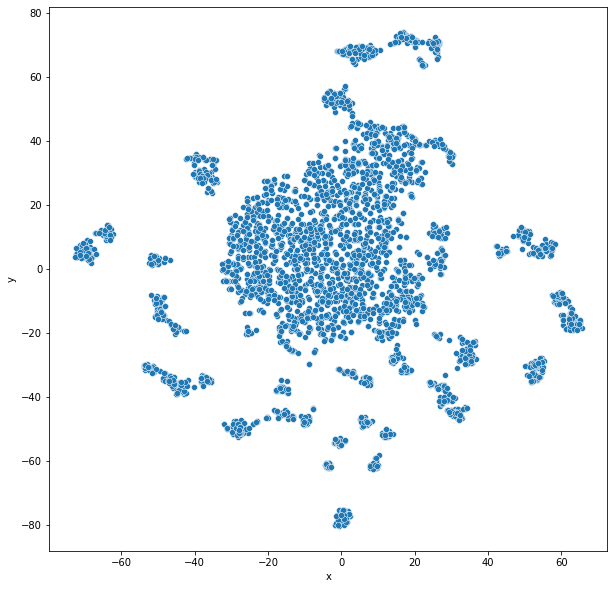

In [57]:
# 시각화
embed_df = pd.DataFrame(embed, columns=['x', 'y'])

plt.figure(figsize=(10, 10))
sns.scatterplot(data=embed_df, x='x', y='y')

<AxesSubplot:xlabel='x', ylabel='y'>

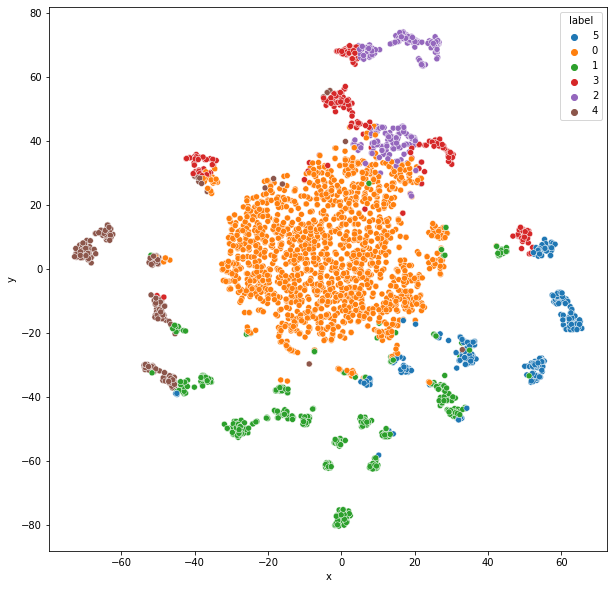

In [58]:
embed_df['label'] = cluster_obj.labels_
embed_df['label'] = embed_df['label'].astype('string')
plt.figure(figsize=(10, 10))
sns.scatterplot(data=embed_df, x='x', y='y', hue='label')